In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import tensorflow as tf
import keras
from keras.layers import Input
from tensorflow.python.framework import ops
import math
from keras.callbacks import EarlyStopping
from keras import optimizers

C:\Users\gandh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading Processed Data

In [2]:
X_train1 = np.loadtxt('X_train1.txt', dtype=float)
X_train2 = np.loadtxt('X_train2.txt', dtype=float)
X_val1 = np.loadtxt('X_val1.txt', dtype=float)
X_val2 = np.loadtxt('X_val2.txt', dtype=float)
X_test1 = np.loadtxt('X_test1.txt', dtype=float)
X_test2 = np.loadtxt('X_test2.txt', dtype=float)
y_train = np.loadtxt("y_train.txt", dtype=float)
y_val = np.loadtxt("y_val.txt", dtype=float)
y_test = np.loadtxt("y_test.txt", dtype=float)

# Converting Watts to kW
y_train/=1000
y_test/=1000
y_val/=1000

In [3]:
X_train1.T.shape, y_train[np.newaxis].shape

((168, 5103), (1, 5103))

## Creating the C-RNN Architecture

In [5]:
X_input = Input([X_train1.shape[1],1])
X_input_2 = Input([X_train2.shape[1],1])

def create_model(X_input, X_input_2):
    
    X1 = keras.layers.Conv1D(kernel_size=(3), filters=64, activation='relu', name='Conv_1')(X_input)
    X1 = keras.layers.MaxPooling1D(pool_size=2, name ='Pool_1')(X1)
    X2 = keras.layers.Conv1D(kernel_size=(5), filters=64, activation='relu', name='Conv_2')(X_input)
    X2 = keras.layers.MaxPooling1D(pool_size=2, name='Pool_2')(X2)
    X3 = keras.layers.Conv1D(kernel_size=(7), filters=64, activation='relu', name='Conv_3')(X_input)
    X3 = keras.layers.MaxPooling1D(pool_size=2, name='Pool_3')(X3)
    X4 = keras.layers.Concatenate(axis=1, name='Concat_1')([X1,X2,X3])
    X5 = keras.layers.LSTM(32, return_sequences=True, name='LSTM_1')(X4)
    X6 = keras.layers.GlobalAveragePooling1D(name='Mean_1')(X5)
    X7 = keras.layers.Flatten()(X_input_2)
    X7 = keras.layers.Dense(32, name='Dense_1')(X7)
    X8 = keras.layers.Concatenate(axis=1, name='Concat_2')([X6,X7])
    X9 = keras.layers.Dense(16, name='Dense_2')(X8)
    Pred = keras.layers.Dense(1, name='Dense_3')(X9)
    
    model = keras.models.Model(inputs=[X_input, X_input_2], outputs=Pred, name='C-RNN')

    return model

In [6]:
model = create_model(X_input, X_input_2)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 168, 1)       0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 166, 64)      256         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_2 (Conv1D)                 (None, 164, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_3 (Conv1D)                 (None, 162, 64)      512         input_1[0][0]                    
__________________________________________________________________________________________________
Pool_1 (Ma

## Training the Model

In [13]:
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse', metrics=['acc'])

X_train1 = np.reshape(X_train1,[X_train1.shape[0], X_train1.shape[1],1])
X_train2 = np.reshape(X_train2,[X_train2.shape[0], X_train2.shape[1],1])
X_val1 = np.reshape(X_val1,[X_val1.shape[0], X_val1.shape[1],1])
X_val2 = np.reshape(X_val2,[X_val2.shape[0], X_val2.shape[1],1])

early_stopping_monitor = EarlyStopping(patience=3)
model.fit([X_train1, X_train2], y_train, epochs=20, validation_data=([X_val1, X_val2], y_val), callbacks=[early_stopping_monitor])

Train on 5103 samples, validate on 1458 samples
Epoch 1/20
5103/5103 [==============================] - 28s 6ms/step - loss: 1.0463 - acc: 0.0000e+00 - val_loss: 0.7294 - val_acc: 0.0000e+00
Epoch 2/20
5103/5103 [==============================] - 36s 7ms/step - loss: 0.7140 - acc: 0.0000e+00 - val_loss: 0.6585 - val_acc: 0.0000e+00
Epoch 3/20
5103/5103 [==============================] - 43s 8ms/step - loss: 0.6392 - acc: 0.0000e+00 - val_loss: 0.7292 - val_acc: 0.0000e+00
Epoch 4/20
5103/5103 [==============================] - 31s 6ms/step - loss: 1.1292 - acc: 0.0000e+00 - val_loss: 0.8242 - val_acc: 0.0000e+00
Epoch 5/20
5103/5103 [==============================] - 28s 5ms/step - loss: 0.6301 - acc: 0.0000e+00 - val_loss: 0.6141 - val_acc: 0.0000e+00
Epoch 6/20
5103/5103 [==============================] - 28s 6ms/step - loss: 0.6003 - acc: 0.0000e+00 - val_loss: 0.6819 - val_acc: 0.0000e+00
Epoch 7/20
5103/5103 [==============================] - 32s 6ms/step - loss: 0.6171 - acc: 0.0

## Saving the Trained Model

In [14]:
try:
    from tensorflow.python.keras.models import load_model

    model.save('model.h5')

    
    new_model = load_model('model.h5')
except:
    pass

X_test1 = np.reshape(X_test1,[X_test1.shape[0], X_test1.shape[1],1])
X_test2 = np.reshape(X_test2,[X_test2.shape[0], X_test2.shape[1],1])

## Evaluating Model and Making Predictions

In [21]:
score_train = model.evaluate([X_train1, X_train2], y_train)
print('MSE_train:', score_train[0])

score_val = model.evaluate([X_val1, X_val2], y_val)
print('MSE_val:', score_val[0])

score_test = model.evaluate([X_test1, X_test2], y_test)
print('MSE_test:', score_test[0])

5103/5103 [==============================] - 6s 1ms/step
MSE: 0.4798101331413014
1458/1458 [==============================] - 2s 1ms/step
MSE: 0.5208419610443429
730/730 [==============================] - 1s 1ms/step
MSE: 0.6139318593560833


In [20]:
pred_test = model.predict([X_test1, X_test2])
pred_train = model.predict([X_train1, X_train2])
pred_val = model.predict([X_val1, X_val2])

(array([8.751912], dtype=float32), 9.136793308333335)

## Calculating $R^2$ Value

In [25]:
len(pred), len(X_test2)

def calc_r_2(pred, y_test):
    mse=0
    for i in range(len(pred)):
        mse+=(pred[i]-y_test[i])**2
    mse/=len(pred)
    # X_test1.shape
    # pred[729], y_test[729]
    mse = mse[0]
    var_y = np.var(y_test)
    return (1-(mse/var_y))

print('train:', calc_r_2(pred_train, y_train))
print('val:', calc_r_2(pred_val, y_val))
print('test:', calc_r_2(pred_test, y_test))

train: 0.8279775810233087
val: 0.817754995327652
test: 0.7774640640364986


## Plotting the $R^2$ Values

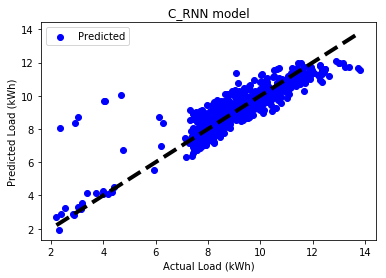

In [26]:
def plot(x,y,x_label=None,y_label=None, title=None, style1=None, color1=None, label1=None, y2=None, label2=None, \
           style2=None, color2=None):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plot1 = plt.scatter(x, y, color=color1)
    plot2, = plt.plot([(y_test).min(), (y_test).max()], [(y_test).min(), (y_test).max()], 'k--', lw=4)
    plt.legend([plot1], [label1, label2])
    plt.show()
    
plot(y_test, pred_test, 'Actual Load (kWh)', 'Predicted Load (kWh)',  'C_RNN model', \
       style1='.', color1='blue', label1='Predicted', y2=y_test, label2='Actual', \
       style2='--', color2='black')
